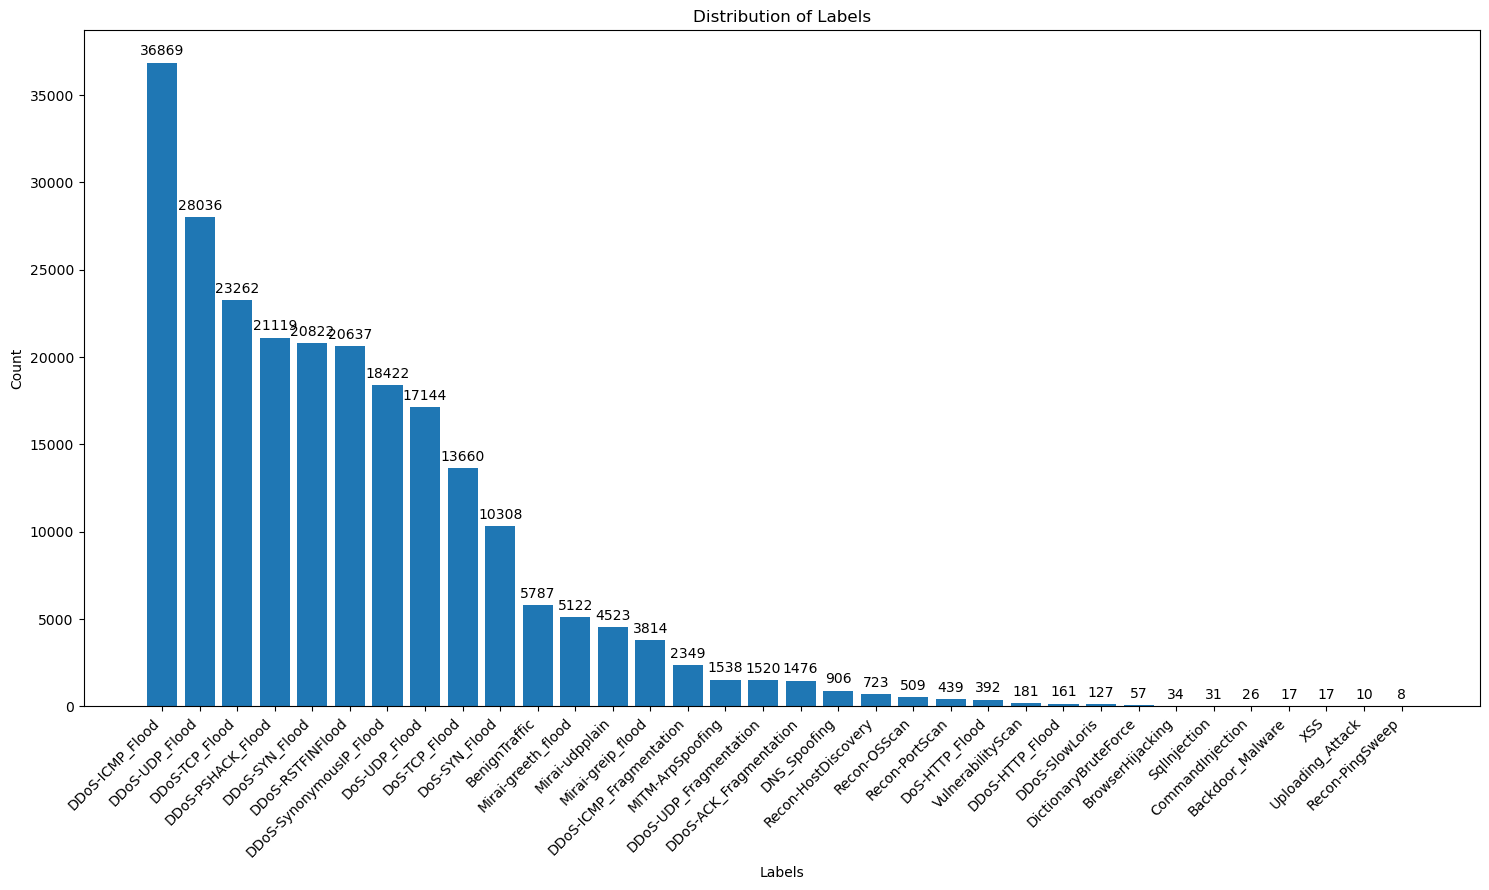

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras import Input, Model
from keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed
from scipy.stats import mode

# Load data
df = pd.read_csv(r'C:\Users\Administrator\Downloads\code\explainable AI\archive\cicds2023.csv', engine='python')

# Visualization: Distribution of Labels
fig, ax = plt.subplots(figsize=(15, 9))
bars = ax.bar(df["label"].value_counts().index, df["label"].value_counts().values, width=0.8)
ax.set_xticklabels(df["label"].value_counts().index, rotation=45, ha='right')
ax.yaxis.set_major_formatter('{:.0f}'.format)
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Labels')
for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(height), xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
plt.tight_layout()
plt.show()

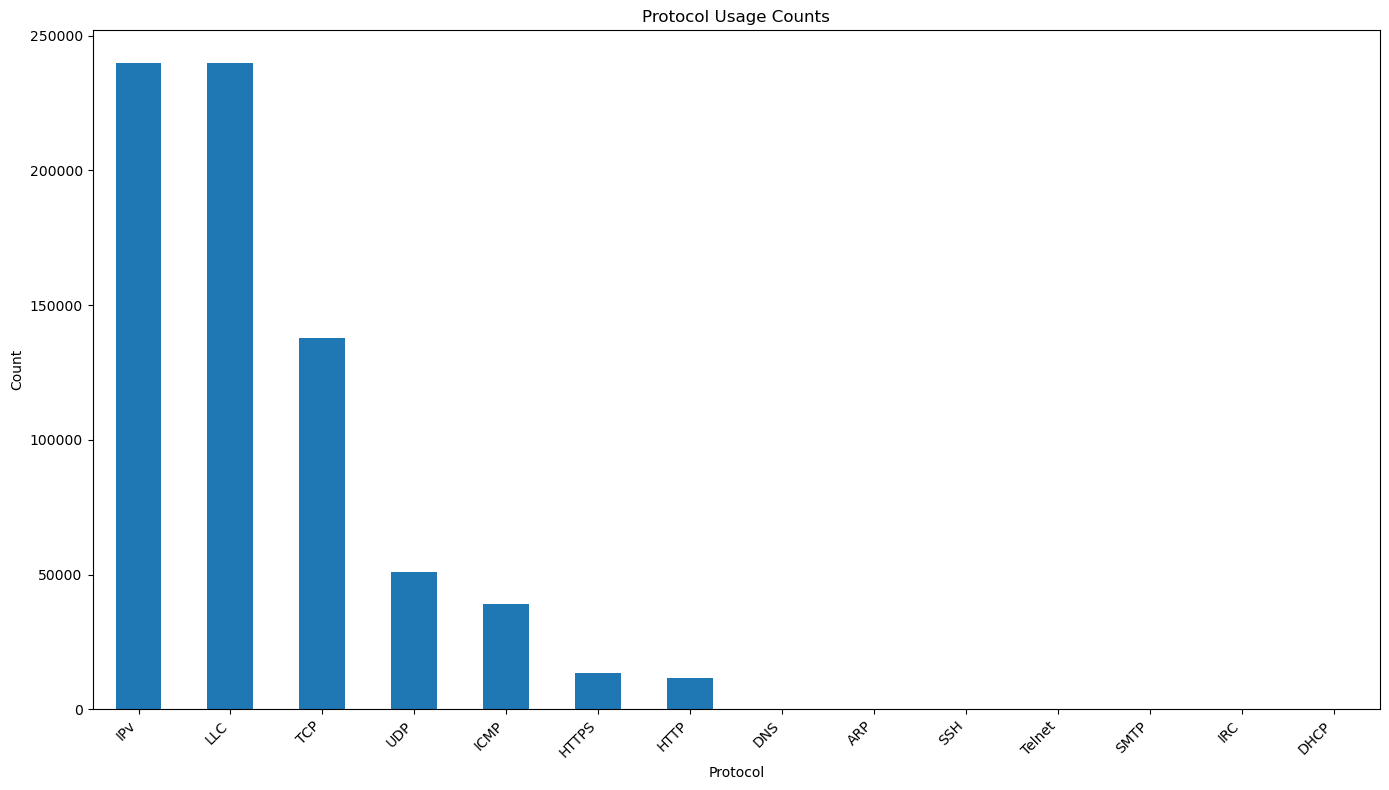

In [3]:
# Visualization: Protocol Usage
protocols = ['HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC']
protocol_counts = df[protocols].sum().sort_values(ascending=False)
plt.figure(figsize=(14, 8))
protocol_counts.plot(kind='bar')
plt.title('Protocol Usage Counts')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [3]:
pip install --upgrade keras


Note: you may need to restart the kernel to use updated packages.


Epoch 1/50
4801/4801 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.6802 - loss: 0.9463 - val_accuracy: 0.7823 - val_loss: 0.4964
Epoch 2/50
4801/4801 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7817 - loss: 0.4987 - val_accuracy: 0.7879 - val_loss: 0.4922
Epoch 3/50
4801/4801 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7873 - loss: 0.4780 - val_accuracy: 0.7884 - val_loss: 0.4737
Epoch 4/50
4801/4801 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7877 - loss: 0.4696 - val_accuracy: 0.7891 - val_loss: 0.4675
Epoch 5/50
4801/4801 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7903 - loss: 0.4615 - val_accuracy: 0.7900 - val_loss: 0.4569
Epoch 6/50
4801/4801 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7906 - loss: 0.4586 - val_accuracy: 0.7933 - val_loss: 0.4560
Epoch 7/50
4801/4801 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7913 - loss: 0.4573 - val_accuracy: 0.7924 - val_loss: 0.4568
Epoch 8/50
4801/4801 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7922 - loss: 0.4545 - 

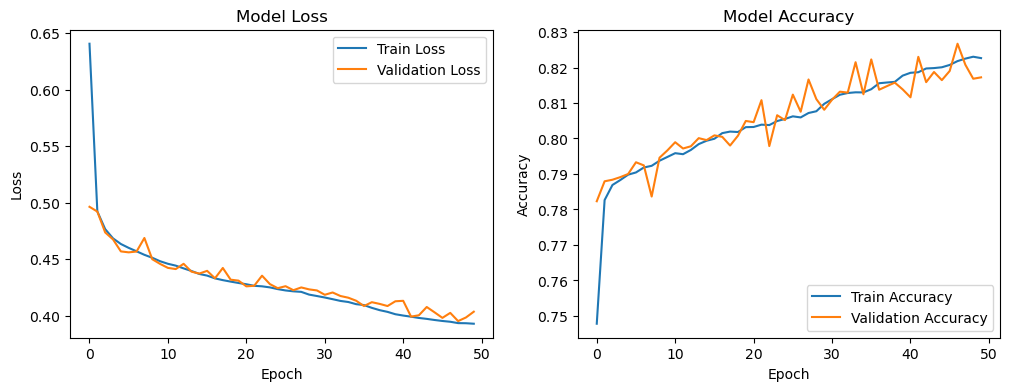

6002/6002 ━━━━━━━━━━━━━━━━━━━━ 2s 289us/step
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input
from keras.callbacks import History

# Assuming df is your DataFrame
# Data Preprocessing
numeric_features = df.select_dtypes(include=[np.number]).columns
df[numeric_features] = df[numeric_features].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df = df.fillna(0)

# Update the mapping to multi-class
mapping = {'BenignTraffic': 0, 'DDoS-ICMP_Flood': 1, 'DDoS-UDP_Flood': 2, 'DDoS-TCP_Flood': 3, 'DDoS-PSHACK_Flood': 4, 
           'DDoS-SYN_Flood': 5, 'DDoS-RSTFINFlood': 6, 'DDoS-SynonymousIP_Flood': 7, 'DDoS-ICMP_Fragmentation': 8, 
           'DDoS-UDP_Fragmentation': 9, 'DDoS-ACK_Fragmentation': 10, 'DDoS-HTTP_Flood': 11, 'DDoS-SlowLoris': 12, 
           'DoS-UDP_Flood': 13, 'DoS-TCP_Flood': 14, 'DoS-SYN_Flood': 15, 'DoS-HTTP_Flood': 16, 'Recon-HostDiscovery': 17, 
           'Recon-OSScan': 18, 'Recon-PortScan': 19, 'Recon-PingSweep': 20, 'VulnerabilityScan': 21, 'MITM-ArpSpoofing': 22, 
           'DNS_Spoofing': 23, 'DictionaryBruteForce': 24, 'BrowserHijacking': 25, 'XSS': 26, 'Uploading_Attack': 27, 
           'SqlInjection': 28, 'CommandInjection': 29, 'Backdoor_Malware': 30, 'Mirai-greeth_flood': 31, 'Mirai-udpplain': 32, 
           'Mirai-greip_flood': 33}
df['label'] = df['label'].map(mapping)

# Separate features and target variable
X = df.drop(columns=["label"])
y = df["label"]

# Convert labels to categorical
y_categorical = to_categorical(y.astype(int))

# Handle NaN in y_train
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
nan_indices = np.isnan(y_train)
mode_value = mode(y_train[~nan_indices])[0]
y_train[nan_indices] = mode_value

# Check for NaN/Infinite values and handle them
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# CNN Feature Extraction
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()
X_train_cnn = X_train_array.reshape((X_train_array.shape[0], X_train_array.shape[1], 1))
X_test_cnn = X_test_array.reshape((X_test_array.shape[0], X_test_array.shape[1], 1))

model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(20, activation='relu', name='feature_layer'),
    Dense(len(mapping), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and capture the training history
history = model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Extract features from CNN
input_layer = Input(shape=(X_train_cnn.shape[1], 1))
flatten_layer = Flatten(name='flatten')(input_layer)
feature_extractor_model = Model(inputs=input_layer, outputs=flatten_layer)
train_features = feature_extractor_model.predict(X_train_cnn)
test_features = feature_extractor_model.predict(X_test_cnn)


In [5]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed

def fitness_function(features, labels, subset):
    if np.sum(subset) != 30:  # Ensure exactly 32 features are selected
        return 0
    selected_features = features[:, subset == 1]
    clf = SVC(kernel='linear')
    scores = cross_val_score(clf, selected_features, labels, cv=5)
    return scores.mean()

def gray_wolf_optimizer(features, labels, population_size=20, max_iter=10, early_stopping_rounds=5):
    num_features = features.shape[1]
    population = np.random.randint(2, size=(population_size, num_features))
    alpha, beta, delta = np.zeros(num_features), np.zeros(num_features), np.zeros(num_features)
    alpha_score, beta_score, delta_score = -np.inf, -np.inf, -np.inf

    no_improvement_counter = 0
    best_score = -np.inf

    for iteration in range(max_iter):
        if no_improvement_counter >= early_stopping_rounds:
            print("Early stopping at iteration", iteration)
            break
        
        a = 2 * (1 - iteration / max_iter)  # Update 'a' outside the inner loop

        fitness_scores = Parallel(n_jobs=-1)(delayed(fitness_function)(features, labels, wolf) for wolf in population)

        for idx, wolf in enumerate(population):
            fitness = fitness_scores[idx]
            if fitness > alpha_score:
                alpha_score, alpha = fitness, wolf.copy()
            elif fitness > beta_score:
                beta_score, beta = fitness, wolf.copy()
            elif fitness > delta_score:
                delta_score, delta = fitness, wolf.copy()

        if alpha_score > best_score:
            best_score = alpha_score
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        for wolf in population:
            for feature in range(num_features):
                r1, r2 = np.random.rand(), np.random.rand()

                A1, C1 = 2 * a * r1 - a, 2 * r2
                D_alpha = np.abs(C1 * alpha[feature] - wolf[feature])
                X1 = alpha[feature] - A1 * D_alpha

                r1, r2 = np.random.rand(), np.random.rand()
                A2, C2 = 2 * a * r1 - a, 2 * r2
                D_beta = np.abs(C2 * beta[feature] - wolf[feature])
                X2 = beta[feature] - A2 * D_beta

                r1, r2 = np.random.rand(), np.random.rand()
                A3, C3 = 2 * a * r1 - a, 2 * r2
                D_delta = np.abs(C3 * delta[feature] - wolf[feature])
                X3 = delta[feature] - A3 * D_delta

                wolf[feature] = (X1 + X2 + X3) / 3

    return alpha

# Example usage
population_size = 20  # Adjust population size
max_iter = 30  # Adjust the number of iterations
early_stopping_rounds = 5  # Early stopping if no improvement over 5 iterations

# Convert NaNs to mode value
mode_value = np.nanmedian(y_train)
y_train = np.nan_to_num(y_train, nan=mode_value)

selected_features = gray_wolf_optimizer(train_features, y_train, population_size=population_size, max_iter=max_iter, early_stopping_rounds=early_stopping_rounds)

# Convert selected_features to a boolean mask
selected_features_mask = selected_features == 1
print("Selected features mask:", selected_features_mask)

# Get the indices of the selected features
selected_feature_indices = np.where(selected_features_mask)[0]

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]
print("Selected feature names:", selected_feature_names.tolist())


Early stopping at iteration 6
Selected features mask: [False False False False  True  True False False  True False False False
  True False False  True  True False False  True  True False False False
 False False False  True False False False False False False  True False
  True False  True  True  True  True False False False False]
Selected feature names: ['Rate', 'Srate', 'syn_flag_number', 'ece_flag_number', 'syn_count', 'fin_count', 'HTTP', 'HTTPS', 'UDP', 'Min', 'AVG', 'Tot size', 'IAT', 'Number', 'Magnitue']


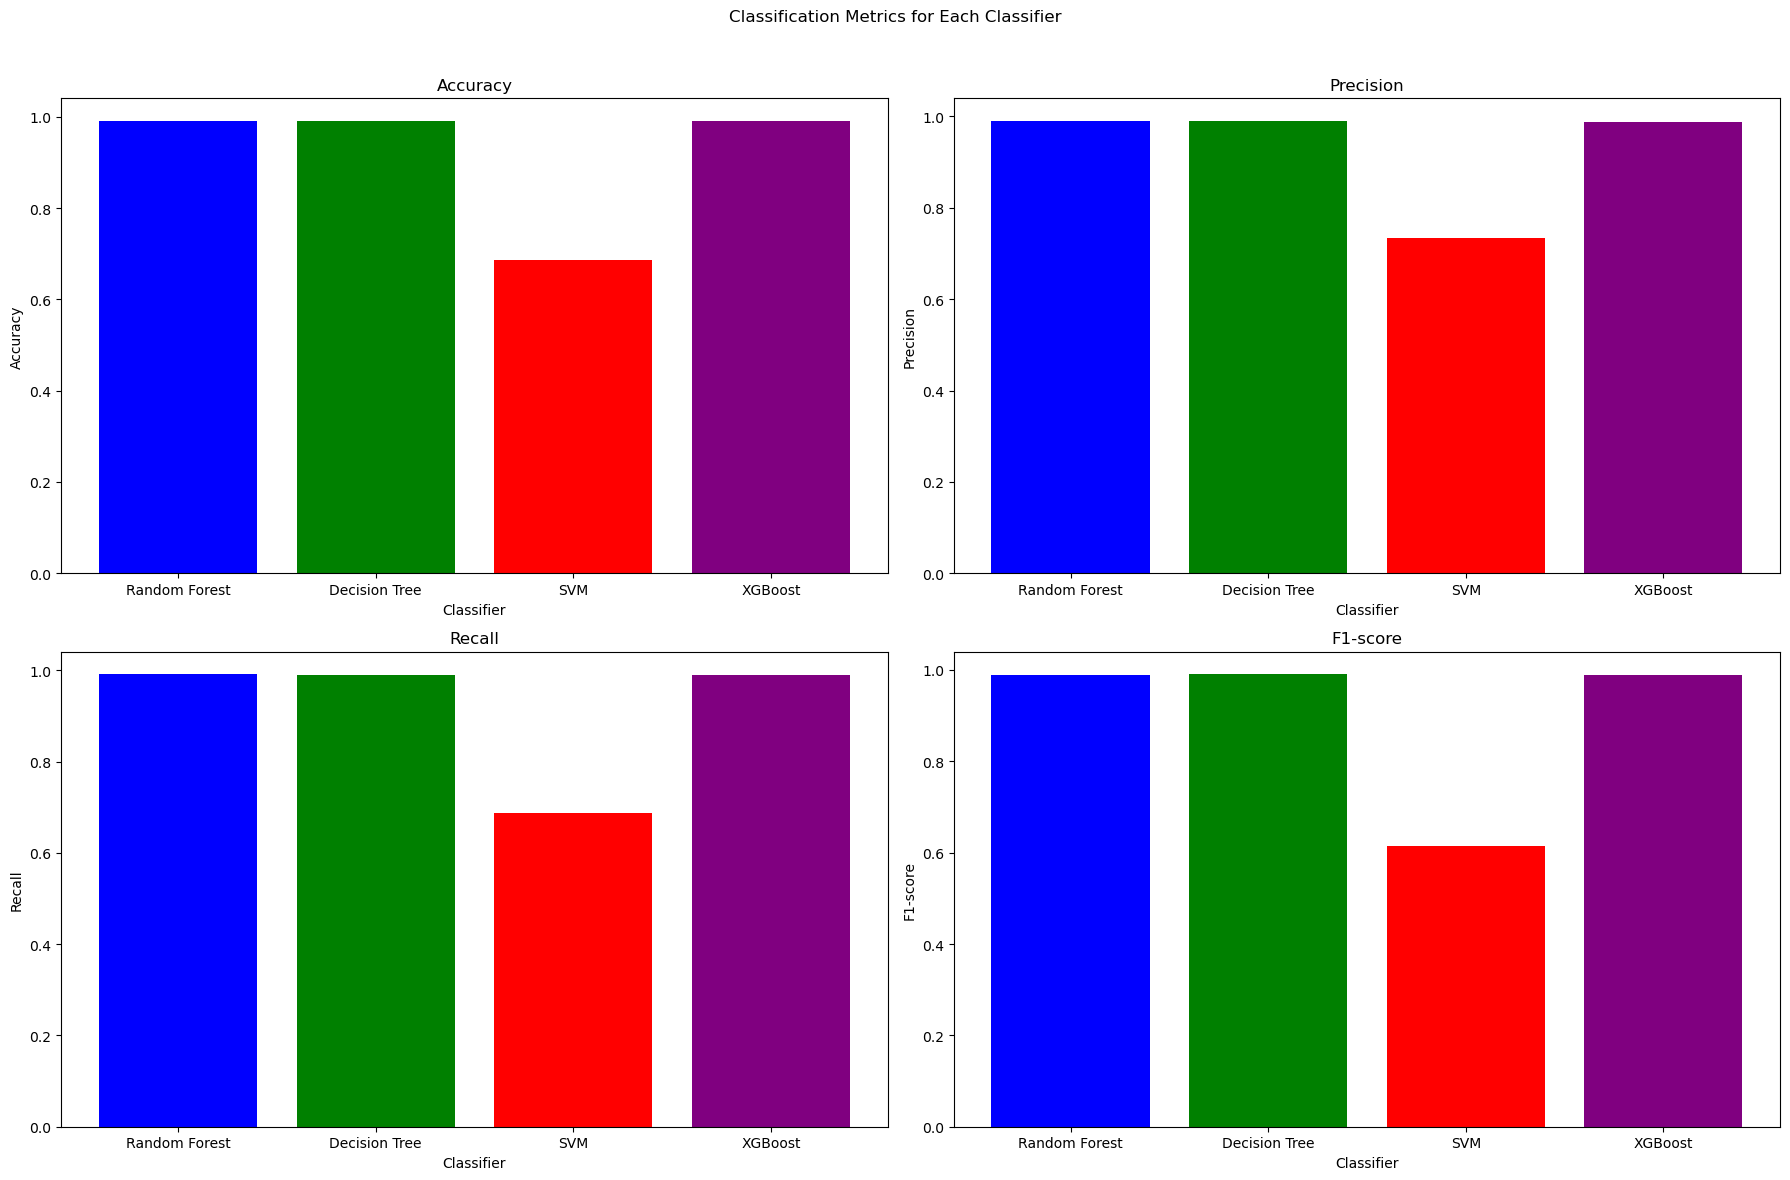

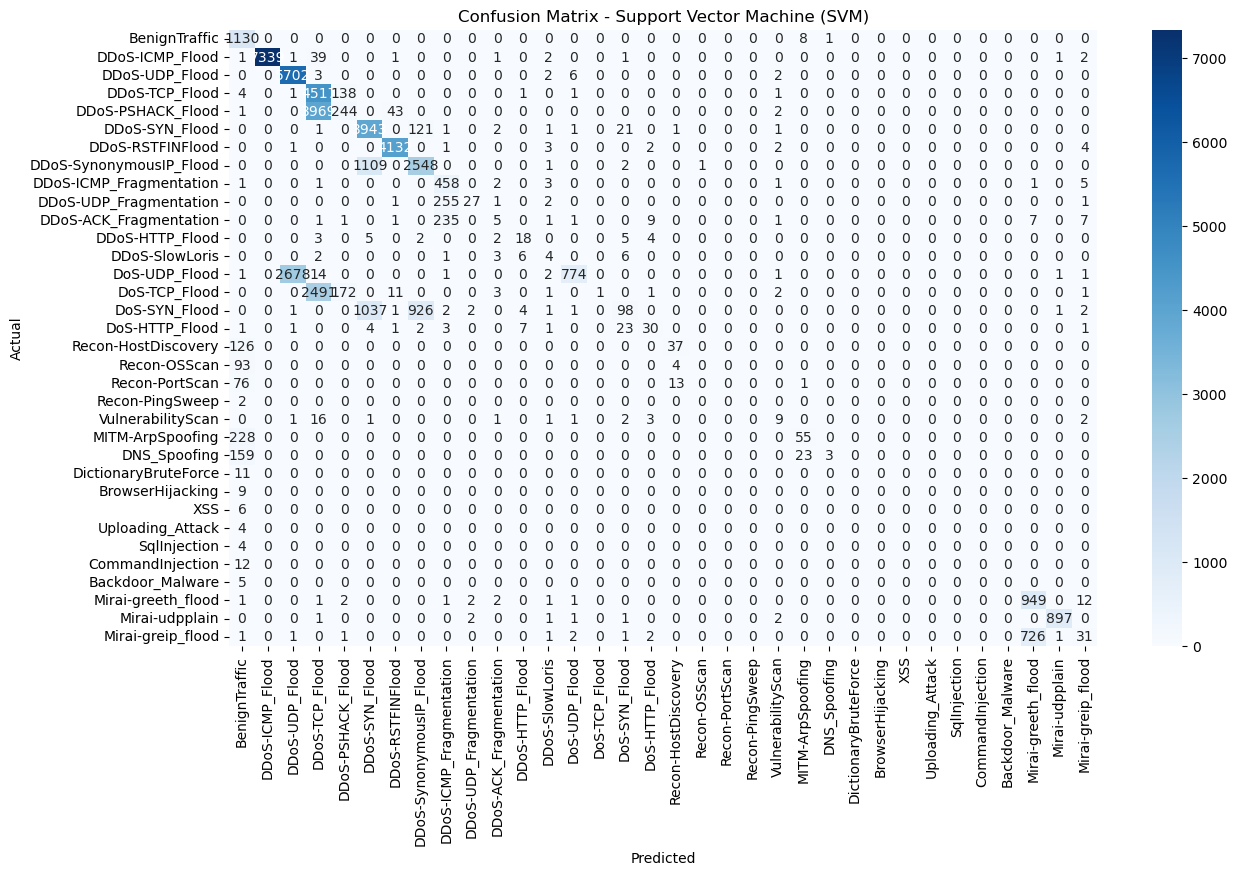

Voting Classifier (Soft Voting):
                         precision    recall  f1-score   support

          BenignTraffic       0.82      0.97      0.89      1139
        DDoS-ICMP_Flood       1.00      1.00      1.00      7388
         DDoS-UDP_Flood       1.00      1.00      1.00      5715
         DDoS-TCP_Flood       1.00      1.00      1.00      4663
      DDoS-PSHACK_Flood       1.00      1.00      1.00      4259
         DDoS-SYN_Flood       1.00      1.00      1.00      4093
       DDoS-RSTFINFlood       1.00      1.00      1.00      4145
DDoS-SynonymousIP_Flood       1.00      1.00      1.00      3661
DDoS-ICMP_Fragmentation       0.99      1.00      0.99       472
 DDoS-UDP_Fragmentation       0.98      0.99      0.99       287
 DDoS-ACK_Fragmentation       1.00      0.99      1.00       269
        DDoS-HTTP_Flood       0.95      0.95      0.95        39
         DDoS-SlowLoris       0.95      0.91      0.93        22
          DoS-UDP_Flood       1.00      1.00      1.00  

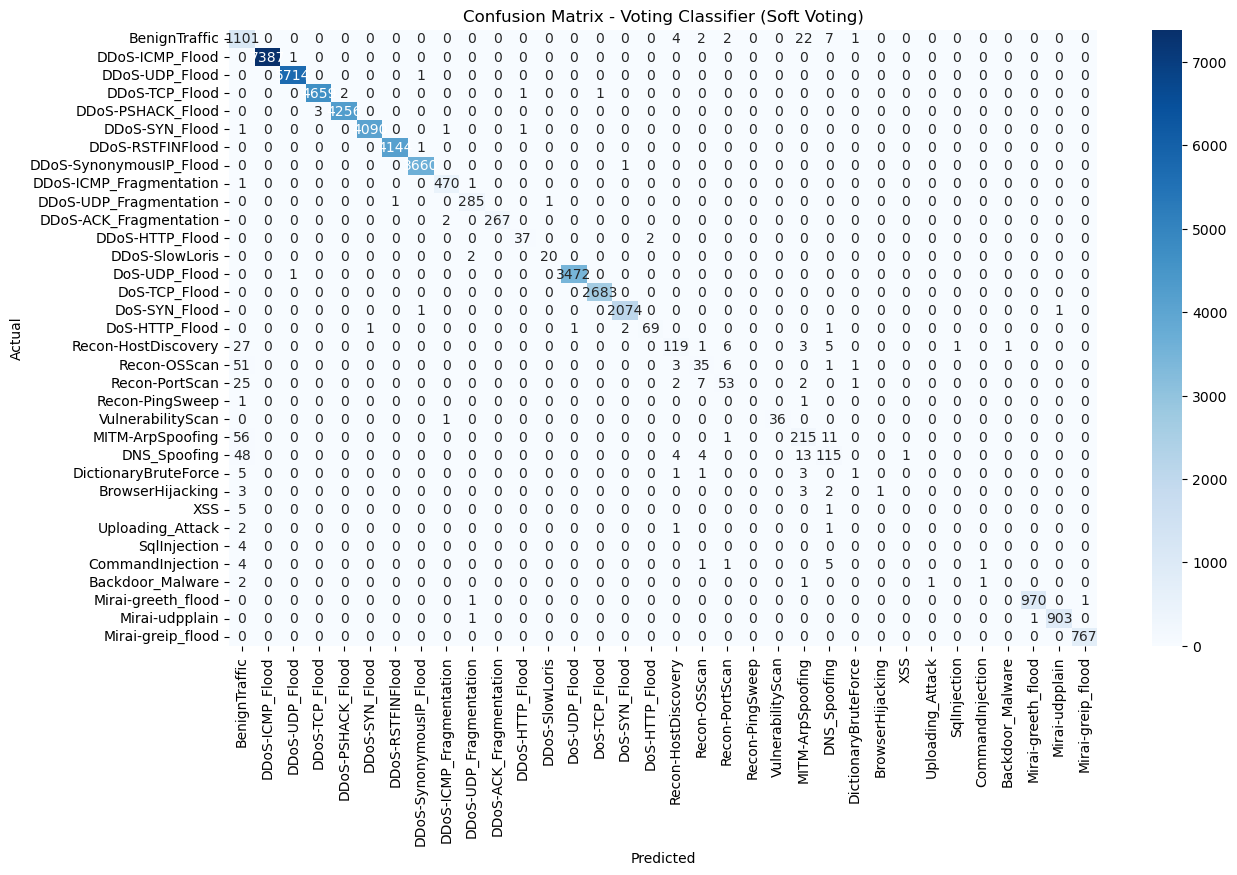

Voting Classifier (Soft Voting) Evaluation:
Accuracy: 0.9915434284524057
Precision: 0.9909795381995571
Recall: 0.9915434284524057
F1-score: 0.9908252435493102


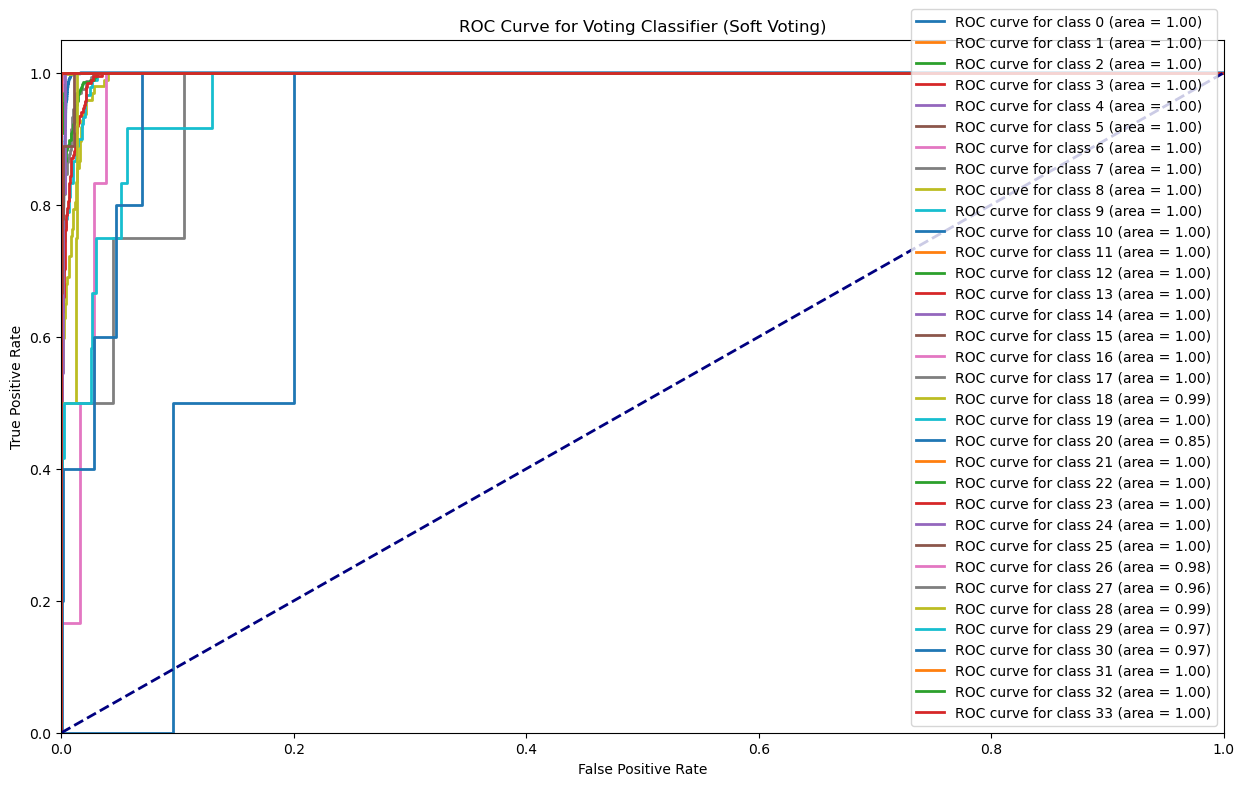

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
import time

# Assuming train_features, test_features, selected_features_mask, y_train, y_test, and mapping are defined

# Train Random Forest Classifier on selected features
X_train_selected = train_features[:, selected_features_mask > 0.5]
X_test_selected = test_features[:, selected_features_mask > 0.5]

# Convert y_train and y_test from one-hot encoding to 1-dimensional arrays
y_train_flat = np.argmax(y_train, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

# Initialize base classifiers
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
dtc = DecisionTreeClassifier(random_state=42)
svc = SVC(probability=True, random_state=42)
xgbc = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Train each base classifier
rfc.fit(X_train_selected, y_train_flat)
dtc.fit(X_train_selected, y_train_flat)
svc.fit(X_train_selected, y_train_flat)
xgbc.fit(X_train_selected, y_train_flat)

# Make predictions using each base classifier
y_pred_rfc = rfc.predict(X_test_selected)
y_pred_dtc = dtc.predict(X_test_selected)
y_pred_svc = svc.predict(X_test_selected)
y_pred_xgbc = xgbc.predict(X_test_selected)

# Evaluate each base classifier
classifiers = ['Random Forest', 'Decision Tree', 'SVM', 'XGBoost']
y_preds = [y_pred_rfc, y_pred_dtc, y_pred_svc, y_pred_xgbc]
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
results = {metric: [] for metric in metrics}

for y_pred in y_preds:
    accuracy = accuracy_score(y_test_flat, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_flat, y_pred, average='weighted')
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1-score'].append(f1)

# Plot bar charts for each metric
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Classification Metrics for Each Classifier')

for ax, metric in zip(axes.flatten(), metrics):
    ax.bar(classifiers, results[metric], color=['blue', 'green', 'red', 'purple'])
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Classifier')
    ax.set_ylabel(metric.capitalize())

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plot confusion matrix for one classifier as an example
conf_matrix_svc = confusion_matrix(y_test_flat, y_pred_svc)
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Blues', xticklabels=list(mapping.keys()), yticklabels=list(mapping.keys()))
plt.title('Confusion Matrix - Support Vector Machine (SVM)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Initialize Voting Classifier with 'soft' voting
voting_clf = VotingClassifier(estimators=[
    ('Random Forest', rfc),
    ('Decision Tree', dtc),
    ('SVM', svc),
    ('XGBoost', xgbc)
], voting='soft')

# Train Voting Classifier
voting_clf.fit(X_train_selected, y_train_flat)

# Make predictions using Voting Classifier
y_pred_voting = voting_clf.predict(X_test_selected)

# Evaluate Voting Classifier
print("Voting Classifier (Soft Voting):")
print(classification_report(y_test_flat, y_pred_voting, target_names=list(mapping.keys())))

# Plot confusion matrix for Voting Classifier
conf_matrix_voting = confusion_matrix(y_test_flat, y_pred_voting)
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix_voting, annot=True, fmt='d', cmap='Blues', xticklabels=list(mapping.keys()), yticklabels=list(mapping.keys()))
plt.title('Confusion Matrix - Voting Classifier (Soft Voting)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Measure the time taken for training and prediction using Voting Classifier
start_time = time.time()
voting_clf.fit(X_train_selected, y_train_flat)
training_time = time.time() - start_time

start_time = time.time()
y_pred_voting = voting_clf.predict(X_test_selected)
prediction_time = time.time() - start_time

# Evaluate Voting Classifier
accuracy = accuracy_score(y_test_flat, y_pred_voting)
precision, recall, fscore, _ = precision_recall_fscore_support(y_test_flat, y_pred_voting, average='weighted')

print(f'Voting Classifier (Soft Voting) Evaluation:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {fscore}')

# Plot ROC curve for each class in Voting Classifier
n_classes = len(mapping)
y_test_bin = LabelEncoder().fit_transform(y_test_flat)
y_pred_proba_voting = voting_clf.predict_proba(X_test_selected)

plt.figure(figsize=(15, 9))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba_voting[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve for class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Voting Classifier (Soft Voting)')
plt.legend(loc="lower right")
plt.show()


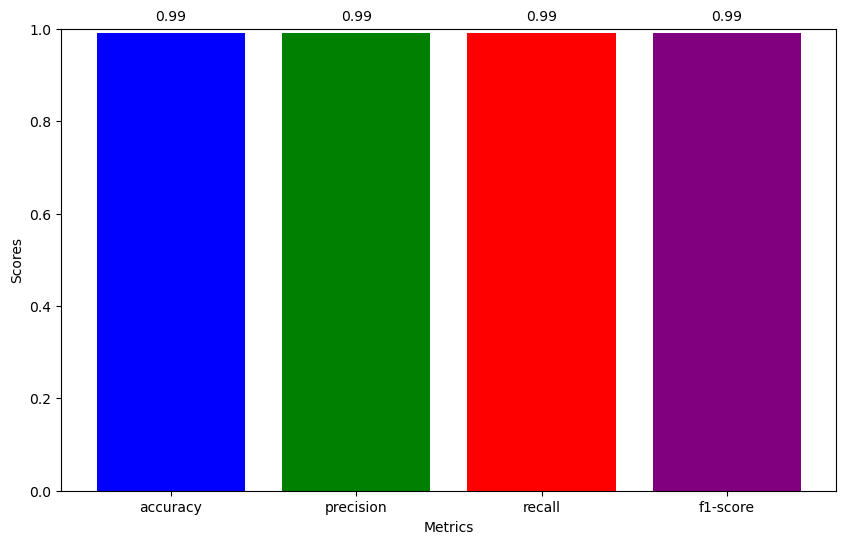

In [14]:
# Plot the metrics in the form of a bar chart
metrics_voting = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': fscore
}

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(metrics_voting.keys(), metrics_voting.values(), color=['blue', 'green', 'red', 'purple'])
#ax.set_title('Voting Classifier Metrics')
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_ylim(0, 1)

# Annotate bars with values
for i, (metric, score) in enumerate(metrics_voting.items()):
    ax.text(i, score + 0.02, f'{score:.2f}', ha='center', va='bottom')

plt.show()

In [15]:
# Print training and prediction time
print(f"Voting Classifier Training Time: {training_time:.2f} seconds")
print(f"Voting Classifier Prediction Time: {prediction_time:.2f} seconds")

# Evaluate Voting Classifier
print("Voting Classifier (Soft Voting):")
print(classification_report(y_test_flat, y_pred_voting, target_names=list(mapping.keys())))

Voting Classifier Training Time: 1311.08 seconds
Voting Classifier Prediction Time: 398.29 seconds
Voting Classifier (Soft Voting):
                         precision    recall  f1-score   support

          BenignTraffic       0.82      0.97      0.89      1139
        DDoS-ICMP_Flood       1.00      1.00      1.00      7388
         DDoS-UDP_Flood       1.00      1.00      1.00      5715
         DDoS-TCP_Flood       1.00      1.00      1.00      4663
      DDoS-PSHACK_Flood       1.00      1.00      1.00      4259
         DDoS-SYN_Flood       1.00      1.00      1.00      4093
       DDoS-RSTFINFlood       1.00      1.00      1.00      4145
DDoS-SynonymousIP_Flood       1.00      1.00      1.00      3661
DDoS-ICMP_Fragmentation       0.99      1.00      0.99       472
 DDoS-UDP_Fragmentation       0.98      0.99      0.99       287
 DDoS-ACK_Fragmentation       1.00      0.99      1.00       269
        DDoS-HTTP_Flood       0.95      0.95      0.95        39
         DDoS-SlowLori

In [18]:
# Evaluate Voting Classifier
accuracy = accuracy_score(y_test_flat, y_pred_voting)
precision, recall, fscore, _ = precision_recall_fscore_support(y_test_flat, y_pred_voting, average='weighted')
cm_voting = confusion_matrix(y_test_flat, y_pred_voting)
fp_voting = cm_voting.sum(axis=0) - np.diag(cm_voting)
fn_voting = cm_voting.sum(axis=1) - np.diag(cm_voting)
false_positive_rate_voting = fp_voting.sum() / (fp_voting.sum() + np.diag(cm_voting).sum())
false_negative_rate_voting = fn_voting.sum() / (fn_voting.sum() + np.diag(cm_voting).sum())

print(f'Voting Classifier (Soft Voting) Evaluation:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {fscore}')
print(f'False Positive Rate: {false_positive_rate_voting}')
print(f'False Negative Rate: {false_negative_rate_voting}')

Voting Classifier (Soft Voting) Evaluation:
Accuracy: 0.9915434284524057
Precision: 0.9909795381995571
Recall: 0.9915434284524057
F1-score: 0.9908252435493102
False Positive Rate: 0.00845657154759425
False Negative Rate: 0.00845657154759425


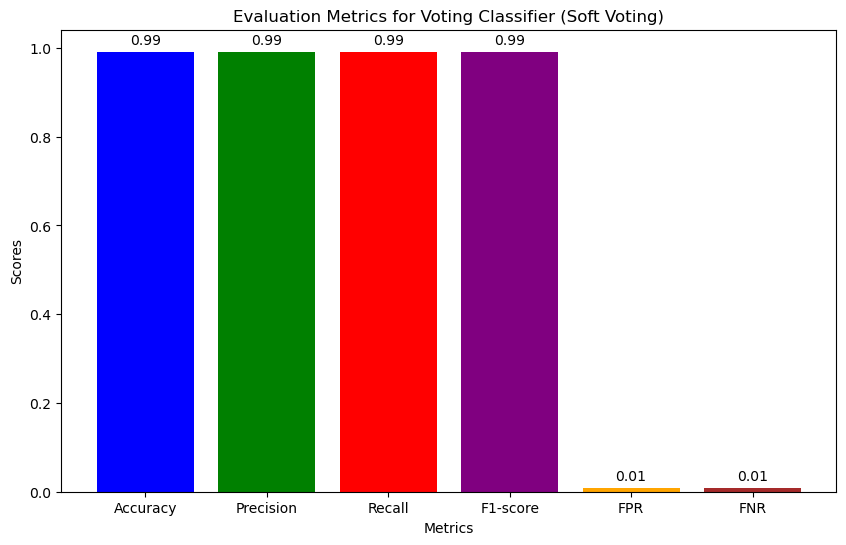

In [20]:
# Evaluate Voting Classifier
accuracy = accuracy_score(y_test_flat, y_pred_voting)
precision, recall, fscore, _ = precision_recall_fscore_support(y_test_flat, y_pred_voting, average='weighted')
cm_voting = confusion_matrix(y_test_flat, y_pred_voting)
fp_voting = cm_voting.sum(axis=0) - np.diag(cm_voting)
fn_voting = cm_voting.sum(axis=1) - np.diag(cm_voting)
false_positive_rate_voting = fp_voting.sum() / (fp_voting.sum() + np.diag(cm_voting).sum())
false_negative_rate_voting = fn_voting.sum() / (fn_voting.sum() + np.diag(cm_voting).sum())

# Collect results into a dictionary
results = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': fscore,
    'FPR': false_positive_rate_voting,
    'FNR': false_negative_rate_voting
}

# Plot the results as a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
metrics = list(results.keys())
values = list(results.values())

ax.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'orange', 'brown'])
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics for Voting Classifier (Soft Voting)')

# Annotate bars with values
for i, v in enumerate(values):
    ax.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

plt.show()

Voting Classifier (Soft Voting):
{'BenignTraffic': {'precision': 0.8241017964071856, 'recall': 0.9666374012291484, 'f1-score': 0.8896969696969697, 'support': 1139.0}, 'DDoS-ICMP_Flood': {'precision': 1.0, 'recall': 0.9998646453708717, 'f1-score': 0.9999323181049069, 'support': 7388.0}, 'DDoS-UDP_Flood': {'precision': 0.9996501049685095, 'recall': 0.999825021872266, 'f1-score': 0.999737555769399, 'support': 5715.0}, 'DDoS-TCP_Flood': {'precision': 0.9993564993564994, 'recall': 0.9991421831438988, 'f1-score': 0.9992493297587132, 'support': 4663.0}, 'DDoS-PSHACK_Flood': {'precision': 0.9995302959135745, 'recall': 0.9992956092979572, 'f1-score': 0.9994129388282259, 'support': 4259.0}, 'DDoS-SYN_Flood': {'precision': 0.9997555609875336, 'recall': 0.9992670412900073, 'f1-score': 0.9995112414467253, 'support': 4093.0}, 'DDoS-RSTFINFlood': {'precision': 0.9997587454764777, 'recall': 0.9997587454764777, 'f1-score': 0.9997587454764777, 'support': 4145.0}, 'DDoS-SynonymousIP_Flood': {'precision':

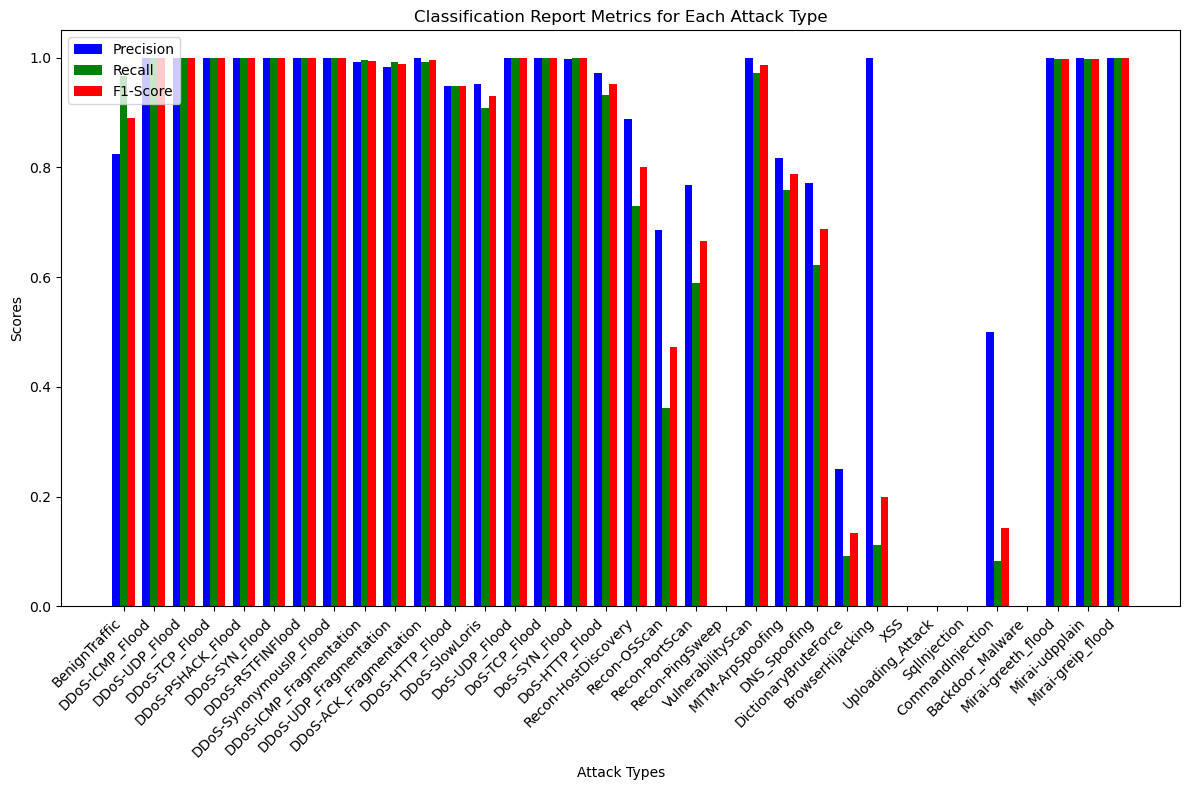

In [17]:
# Evaluate Voting Classifier
print("Voting Classifier (Soft Voting):")
report = classification_report(y_test_flat, y_pred_voting, target_names=list(mapping.keys()), output_dict=True)
print(report)

# Extract precision, recall, and f1-score for each class
attack_types = list(mapping.keys())
precisions = [report[attack]['precision'] for attack in attack_types]
recalls = [report[attack]['recall'] for attack in attack_types]
f1_scores = [report[attack]['f1-score'] for attack in attack_types]

# Plot classification report metrics as bar chart for each attack type
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.25
x = np.arange(len(attack_types))

bars1 = ax.bar(x - bar_width, precisions, bar_width, label='Precision', color='blue')
bars2 = ax.bar(x, recalls, bar_width, label='Recall', color='green')
bars3 = ax.bar(x + bar_width, f1_scores, bar_width, label='F1-Score', color='red')

ax.set_xlabel('Attack Types')
ax.set_ylabel('Scores')
ax.set_title('Classification Report Metrics for Each Attack Type')
ax.set_xticks(x)
ax.set_xticklabels(attack_types, rotation=45, ha='right')
ax.legend()

# Annotate bars with values
#def annotate_bars(bars):
#    for bar in bars:
#        height = bar.get_height()
#        ax.annotate(f'{height:.2f}',
#                    xy=(bar.get_x() + bar.get_width() / 2, height),
#                    xytext=(0, 3),  # 3 points vertical offset
#                    textcoords="offset points",
#                    ha='center', va='bottom')

#annotate_bars(bars1)
#annotate_bars(bars2)
#annotate_bars(bars3)

plt.tight_layout()
plt.show()

Accuracy: 0.9898562799416788
Training Time: 8.296815156936646 seconds
Prediction Time: 0.0937502384185791 seconds
Precision of XGBoost: 0.9886101854610883
Recall of XGBoost: 0.9898562799416788
F1-score of XGBoost: 0.9891606360761511
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1139
           1       1.00      1.00      1.00      7388
           2       1.00      1.00      1.00      5715
           3       1.00      1.00      1.00      4663
           4       1.00      1.00      1.00      4259
           5       1.00      1.00      1.00      4093
           6       1.00      1.00      1.00      4145
           7       1.00      1.00      1.00      3661
           8       1.00      1.00      1.00       472
           9       1.00      1.00      1.00       287
          10       1.00      1.00      1.00       269
          11       0.97      0.92      0.95        39
          12       0.90      0.86      0.88        22
          

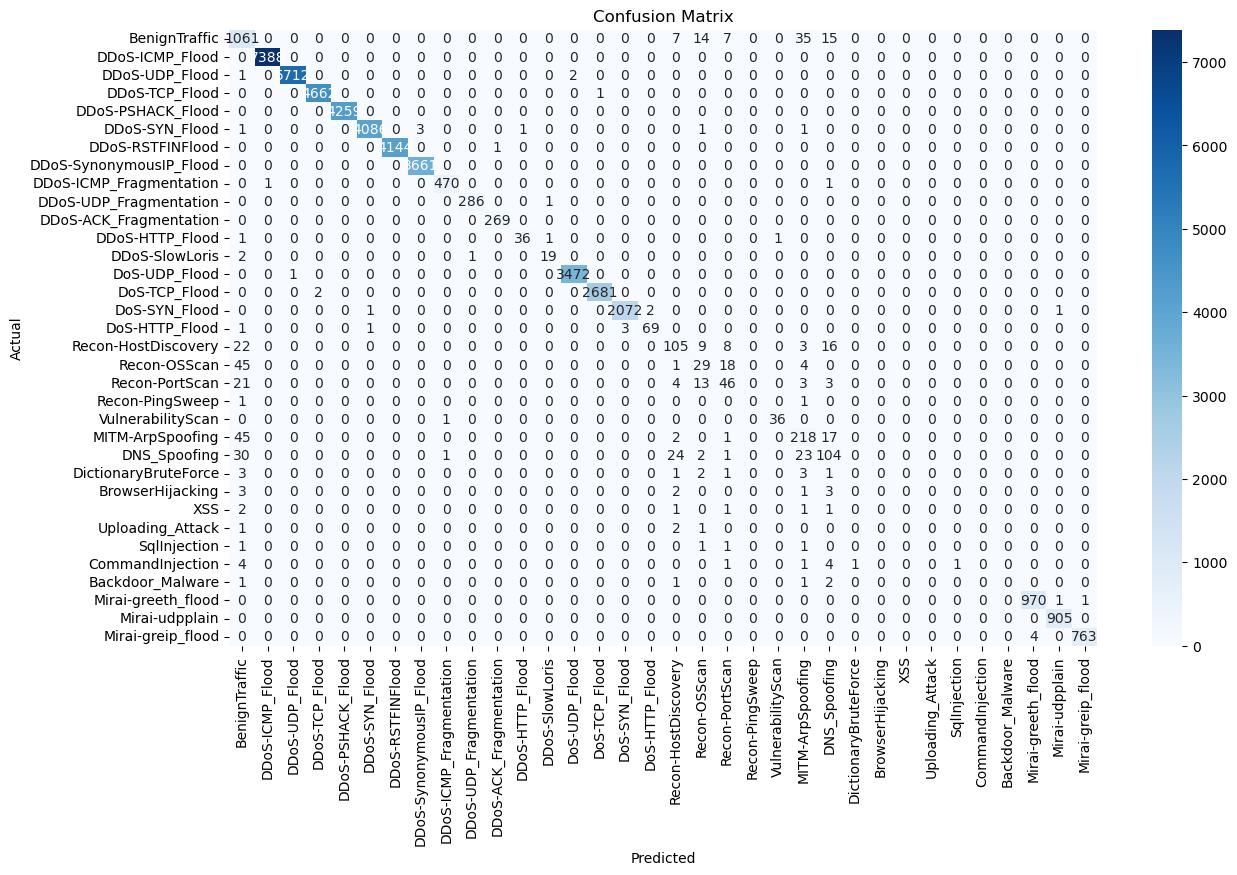

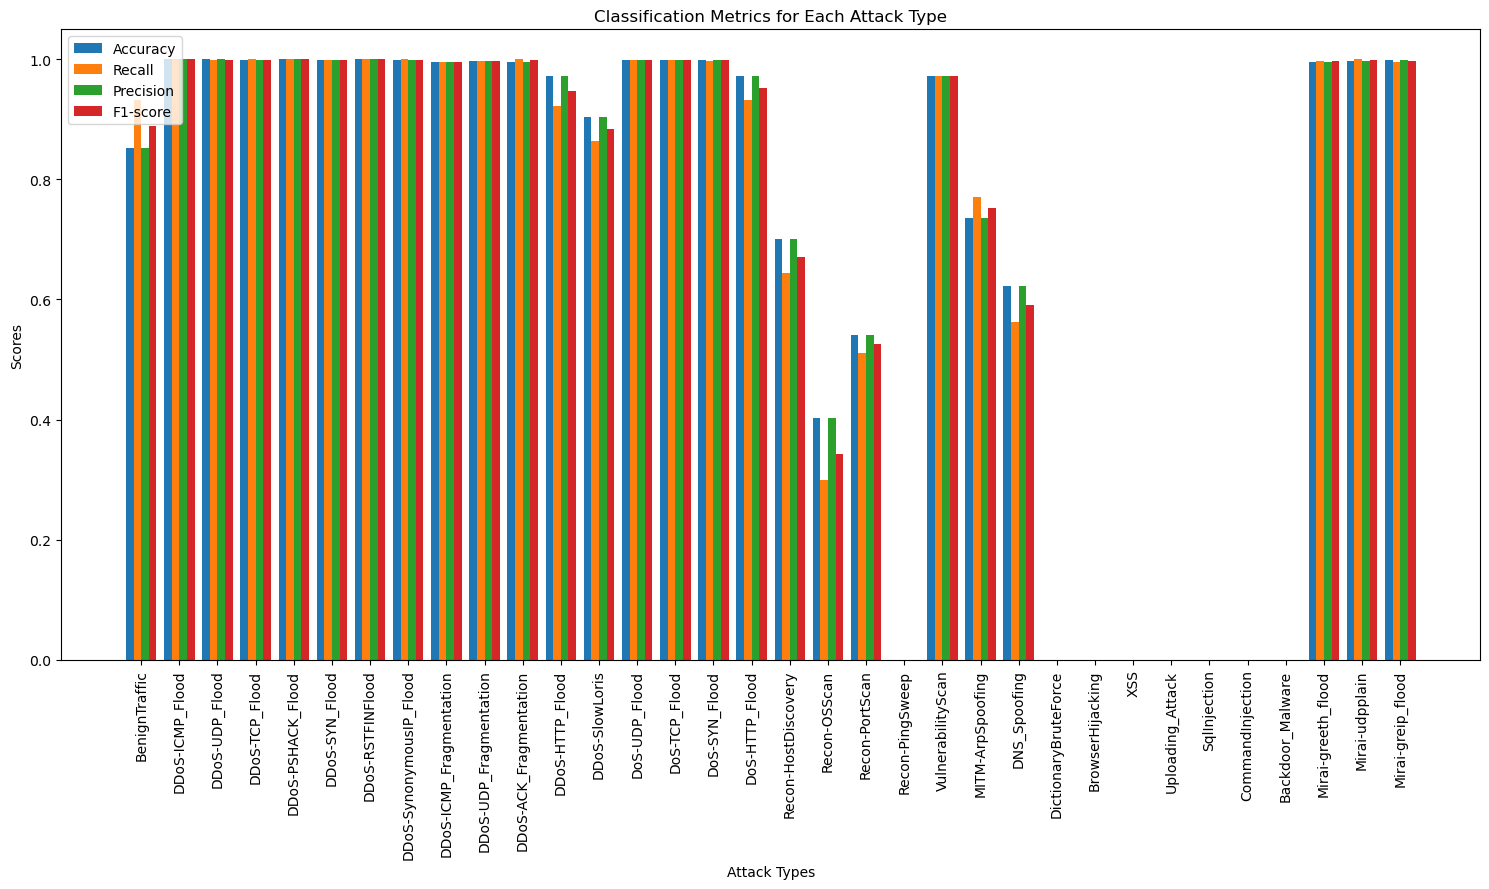

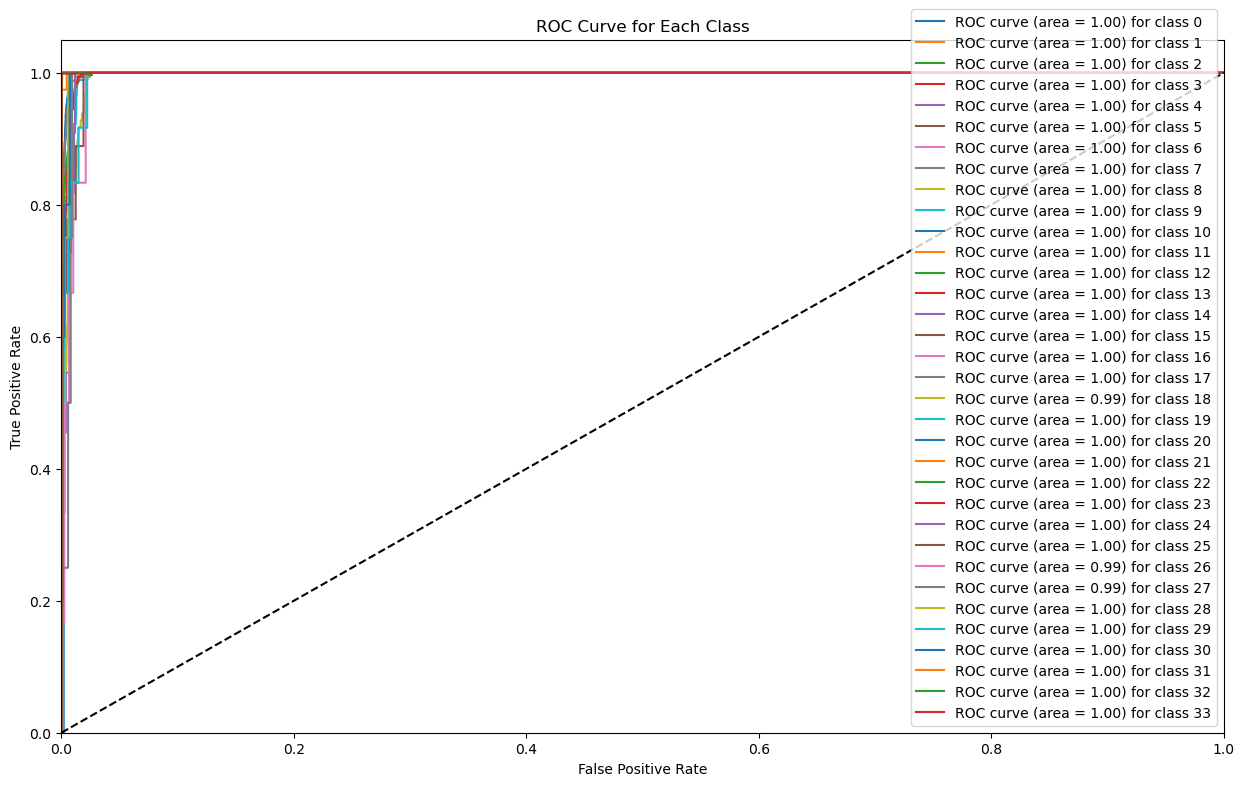

In [8]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score
import time
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import accuracy_score
import time
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras import Input, Model
from keras.utils import to_categorical
from xgboost import XGBClassifier
from joblib import Parallel, delayed
import time
from scipy.stats import mode
selected_train_features = train_features[:, selected_features_mask > 0.5]
selected_test_features = test_features[:, selected_features_mask > 0.5 ]

# Measure the time taken for training the XGBoost classifier
start_time = time.time()
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(selected_train_features, np.argmax(y_train, axis=1))
training_time = time.time() - start_time

# Measure the time taken for prediction
start_time = time.time()
y_pred = xgb.predict(selected_test_features)
prediction_time = time.time() - start_time

# Evaluate the classifier
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print(f'Accuracy: {accuracy}')
print(f'Training Time: {training_time} seconds')
print(f'Prediction Time: {prediction_time} seconds')
precision, recall, fscore, _ = precision_recall_fscore_support(np.argmax(y_test, axis=1), y_pred, average='weighted')
print(f'Precision of XGBoost: {precision}')
print(f'Recall of XGBoost: {recall}')
print(f'F1-score of XGBoost: {fscore}')
print(classification_report(np.argmax(y_test, axis=1), y_pred))

# Plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.figure(figsize=(14, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(mapping.keys()), yticklabels=list(mapping.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compute per-class metrics
report = classification_report(np.argmax(y_test, axis=1), y_pred, output_dict=True)

# Extract metrics for each class
class_names = list(mapping.keys())
accuracy_per_class = [report[str(i)]['precision'] for i in range(len(class_names))]
recall_per_class = [report[str(i)]['recall'] for i in range(len(class_names))]
precision_per_class = [report[str(i)]['precision'] for i in range(len(class_names))]
f1_per_class = [report[str(i)]['f1-score'] for i in range(len(class_names))]

# Bar chart for metrics
fig, ax = plt.subplots(figsize=(15, 9))
bar_width = 0.2
index = np.arange(len(class_names))

bar1 = ax.bar(index, accuracy_per_class, bar_width, label='Accuracy')
bar2 = ax.bar(index + bar_width, recall_per_class, bar_width, label='Recall')
bar3 = ax.bar(index + 2 * bar_width, precision_per_class, bar_width, label='Precision')
bar4 = ax.bar(index + 3 * bar_width, f1_per_class, bar_width, label='F1-score')

ax.set_xlabel('Attack Types')
ax.set_ylabel('Scores')
ax.set_title('Classification Metrics for Each Attack Type')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(class_names, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

# ROC Curve for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], xgb.predict_proba(selected_test_features)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(15, 9))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()
